<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Примем, что значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


**Цель проекта:** Обучить модель для прогнозирования количества заказов такси на следующий час.

**Описание данных:** Датасет с историческими данными о количестве заказов такси на определенном временном интервале.

## Подготовка

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.9 MB/s eta 0:00:00


Импортируем необходимые библиотеки:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

from catboost import CatBoostRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

Считаем данные из csv-файла в датафрейм, изменив тип данных столбца datetime на int64 и установив индекс таблицы равным этому столбцу, сохраним в переменную и выведем ее на экран:

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime'])

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


 Проверим, в хронологическом ли порядке расположены даты и время:

In [4]:
print(data.index.is_monotonic)

True


<ipython-input-4-32a0fbcdd322>:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  print(data.index.is_monotonic)


Выведем основную информацию о датафрейме на экран:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Произведем ресемплирование датафрейма, выбрав интервал в один час и вычислив суммарное количество заказов:

In [6]:
data = data.resample('1H').sum()

Выведем информацию об обновленном датафрейме на экран:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Построим график временного ряда:

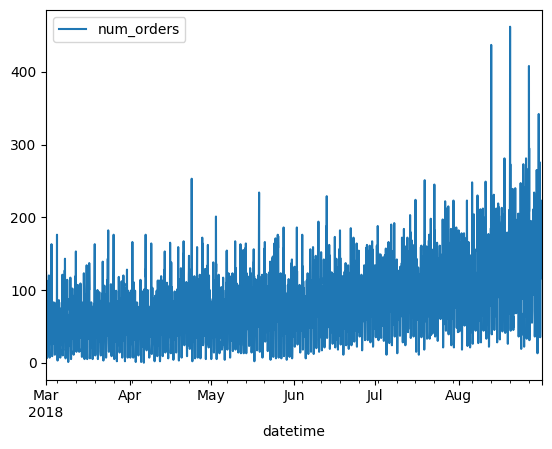

In [8]:
data.plot();

**Вывод:** В датасете представлены данные за весну-лето 2018 года. На графике видно, что количество заказов в час плавно растет от марта к июлю, а в августе наблюдается заметный прирост и пик значений.

## Анализ

Скопируем датафрейм:

In [9]:
data_rm = data.copy()

Добавим в копию столбец rolling_mean скользящее среднее с размером окна, равным 10. Выведем на экран графики энергопотребления:

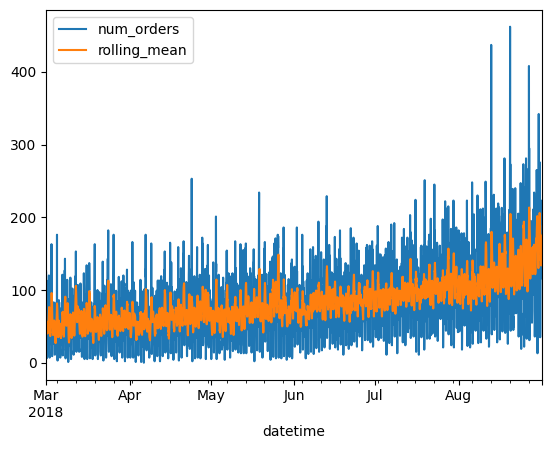

In [10]:
data_rm['rolling_mean'] = data_rm.rolling(10).mean()
data_rm.plot();

Разложим временной ряд на тренд и сезонную компоненту:

In [11]:
decomposed = seasonal_decompose(data)

Выведем графики этих составляющих ряда:

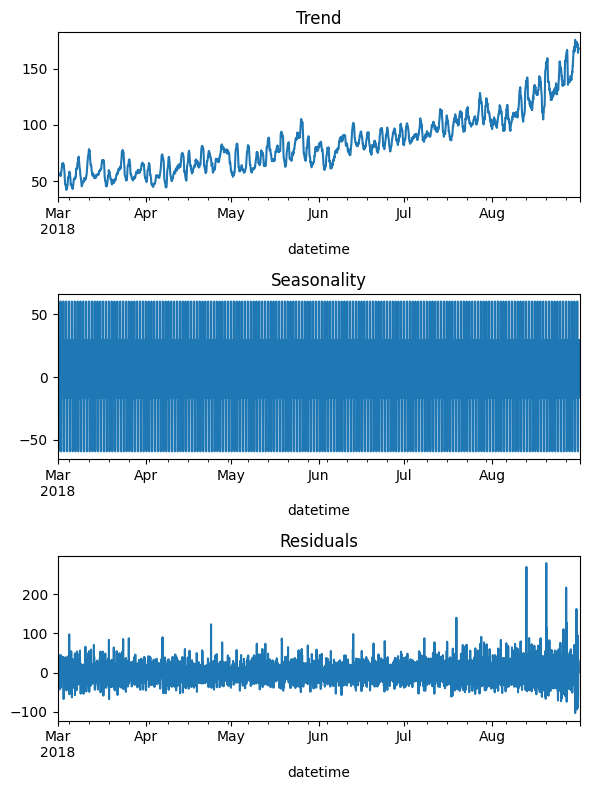

In [12]:
plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Для большей наглядности, построим график сезонной составляющей за первые 15 дней июня:

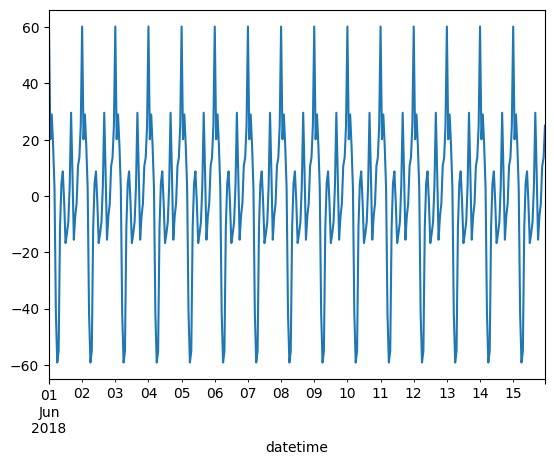

In [13]:
decomposed.seasonal['2018-06-01':'2018-06-15'].plot();

Определим скользящее стандартное отклонение и выведем его на графике:

<Axes: xlabel='datetime'>

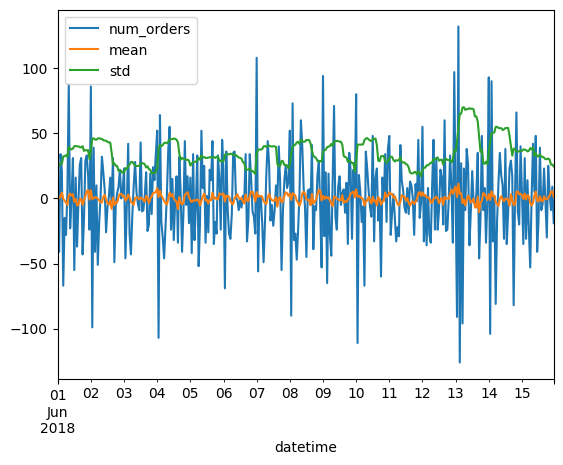

In [14]:
data1 = data - data.shift()
data1['mean'] = data1['num_orders'].rolling(15).mean()
data1['std'] = data1['num_orders'].rolling(15).std()
data1['2018-06-01':'2018-06-15'].plot()

**Вывод:** Тренд заказов такси связан со временем года. А из графика сезонной составляющей видно, что максимум заказов приходится на утро, затем происходят значительный спад и постепенный рост их количества к вечеру.

У временного ряда меняются среднее значение и стандартное отклонение, но диапазон не очень велик, соответственно, данные можно прогнозировать.

## Обучение

Напишем функцию make_features(), чтобы прибавить к таблице четыре новых календарных признака: месяц, день, день недели и час. Добавим аргумент max_lag, который задаст максимальный размер отставания и аргумент rolling_mean_size, который задаст ширину окна:

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data_ml = data.copy()
    data_ml['month'] = data_ml.index.month
    data_ml['day'] = data_ml.index.day
    data_ml['dayofweek'] = data_ml.index.dayofweek
    data_ml['hour'] = data_ml.index.hour

    for lag in range(1, max_lag + 1):
        data_ml['lag_{}'.format(lag)] = data_ml['num_orders'].shift(lag)

    data_ml['rolling_mean'] = data_ml['num_orders'].shift().rolling(rolling_mean_size).mean()

    return data_ml

data_ml = make_features(data, 4, 4)  # зададим "четыре" в качестве значений обоих признаков
data_ml.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,86.5


Разделим датасет на обучающую и тестовую выборки:

In [16]:
train, test = train_test_split(data_ml, shuffle=False, test_size=0.1)

Удалим пропуски из обучающей выборки:

In [17]:
train = train.dropna()

Выделим признаки и целевой признак:

In [18]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

In [19]:
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Создадим объект TimeSeriesSplit для последующей кросс-валидации:

In [20]:
n_splits = 5  # разделим его на пять частей
tscv = TimeSeriesSplit(n_splits)

Обучим модель на основе линейной регрессии и определим для нее значение среднеквадратичной ошибки:

In [21]:
model = LinearRegression()

model.fit(features_train, target_train)
predictions_train = model.predict(features_train)

# Применим кросс-валидацию, добавив в качестве аргументов TimeSeriesSplit и метрику RMSE:
scores = cross_val_score(model, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error')
rmse = sum(scores)/len(scores)

print('RMSE модели:' , -rmse)

RMSE модели: 31.460031058953415


Обучим модель на основе дерева решений, определив для нее оптимальные гиперпараметры:

In [22]:
best_model = None
best_result = 10000
best_leaf_nodes = 0
best_depth = 0

for nodes in range(2, 50):
    for depth in range(2, 50):

        model = DecisionTreeRegressor(random_state=12345, max_depth=depth, max_leaf_nodes=nodes)

        model.fit(features_train, target_train)
        predictions_train = model.predict(features_train)
        scores = cross_val_score(model, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error')
        rmse = sum(scores)/len(scores)

        result = rmse

        if result < best_result:
            best_model = model
            best_result = result
            best_leaf_nodes = nodes
            best_depth = depth

print("RMSE лучшей модели:", -best_result, "Количество узлов листьев:", best_leaf_nodes, "Глубина дерева:", best_depth)

RMSE лучшей модели: 36.36226560360139 Количество узлов листьев: 2 Глубина дерева: 2


Обучим модель на основе случайного леса, определив для нее оптимальные гиперпараметры:

In [23]:
best_model = None
best_result = 10000
best_estimators = 0
best_depth = 0

for est in range(1, 20):
    for depth in range(1, 20):

        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)

        model.fit(features_train, target_train)
        scores = cross_val_score(model, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error')
        result = sum(scores)/len(scores)

        if result < best_result:
            best_model = model
            best_result = result
            best_estimators = est
            best_depth = depth

print("RMSE лучшей модели:", -best_result, "Количество оценщиков:", best_estimators, "Глубина дерева:", best_depth)

RMSE лучшей модели: 36.20264956494573 Количество оценщиков: 1 Глубина дерева: 1


Обучим модель на основе LGBMRegressor, определив для нее оптимальные гиперпараметры:

In [24]:
best_model = None
best_result = 10000
best_iterations = 0
best_leaf = 0

for itr in range(90, 110):
    for leaf in range(10, 20):

        model = LGBMRegressor(num_iterations=itr, min_data_in_leaf=leaf, verbose=-1)

        model.fit(features_train, target_train)
        scores = cross_val_score(model, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error')
        result = sum(scores)/len(scores)

        if result < best_result:
            best_model = model
            best_result = result
            best_iterations = itr
            best_leaf = leaf

print("RMSE лучшей модели:", -best_result, "Число деревьев в ансамбле:", best_iterations, "Минимальное количество семплов:", best_leaf)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

RMSE лучшей модели: 25.751912269736334 Число деревьев в ансамбле: 108 Минимальное количество семплов: 12


Обучим модель на основе CatBoostRegressor:

In [25]:
model = CatBoostRegressor(verbose=False)

model.fit(features_train, target_train, verbose=False)
scores = cross_val_score(model, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error')
rmse = sum(scores)/len(scores)

print('RMSE модели:' , -rmse)

RMSE модели: 25.387914674124712


**Вывод:** Наилучшим образом себя показала модель, обученная на основе CatBoostRegressor. Значение метрики RMSE для нее составило 25,39.

## Тестирование

In [26]:
model = CatBoostRegressor(verbose=False)

model.fit(features_train, target_train, verbose=False)
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions, squared=False)

print('RMSE модели:' , rmse)

RMSE модели: 44.901696845750855


Изобразим реальные тестовые значения и предсказания на графике:

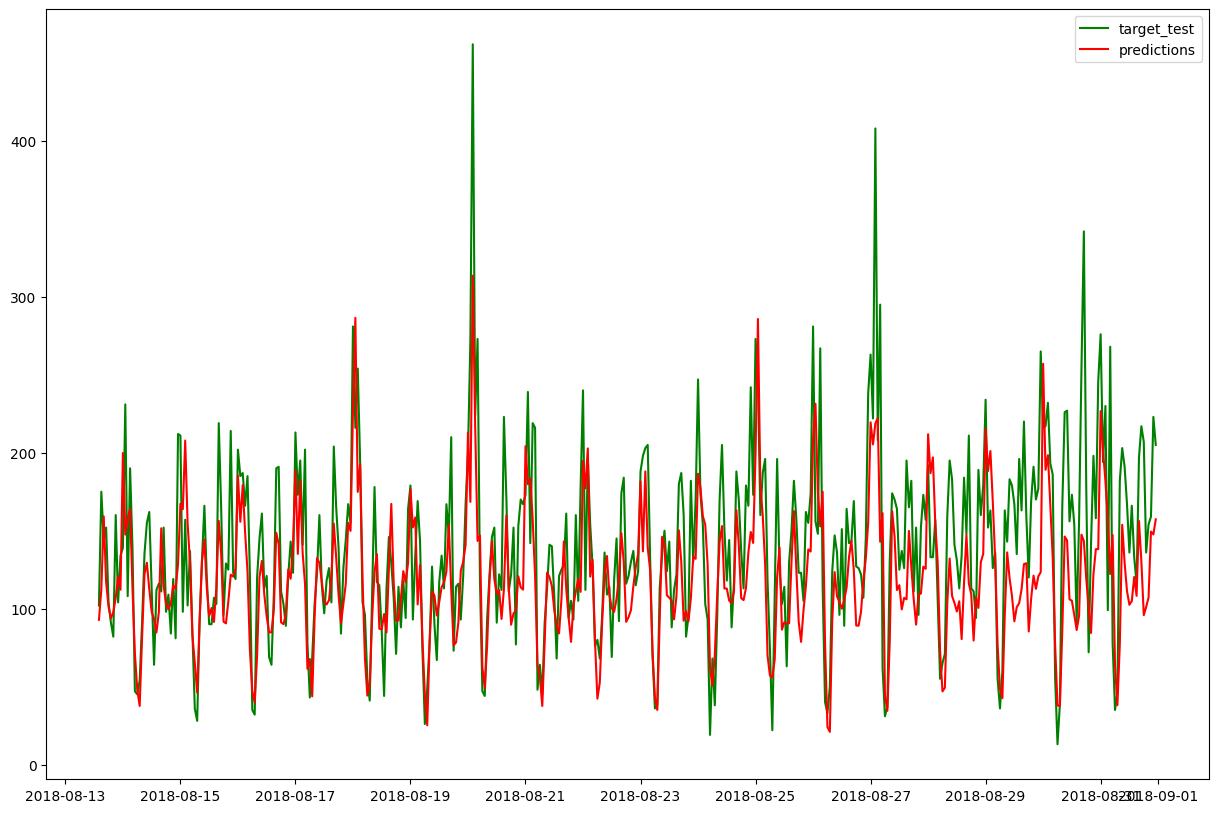

In [27]:
plt.figure(figsize=(15,10))
plt.plot(target_test.index, target_test, 'g-')
plt.plot(target_test.index, predictions, 'r-')
plt.legend(['target_test', 'predictions']);

**Вывод:** При проверке модели CatBoostRegressor на тестовой выборке, значение метрики RMSE составило 44,9.

## Общий вывод

 В датасете представлены данные за весну-лето 2018 года. В ходе предобработки тип данных столбца datetime изменен на int64, индекс таблицы установлен равным этому столбцу. Произведено ресемплирование датафрейма с интервалом в один час и вычислено суммарное количество заказов. Построен график, на котором видно, что количество заказов в час плавно растет от марта к июлю, а в августе наблюдается заметный прирост и пик значений.

 В ходе анализа данных установлено, что тренд заказов такси связан со временем года. А из графика сезонной составляющей видно, что максимум заказов приходится на утро, затем происходят значительный спад и постепенный рост их количества к вечеру. У временного ряда меняются среднее значение и стандартное отклонение, но диапазон не очень велик, соответственно, данные можно прогнозировать.

В ходе прогнозирования были обучены следующие модели: линейная регрессия, дерево решений, случайный лес, LGBMRegressor и CatBoostRegressor. Наилучшим образом себя показала модель, обученная на основе CatBoostRegressor. Значение метрики RMSE для нее составило 25,39.

При проверке модели CatBoostRegressor на тестовой выборке, значение метрики RMSE составило 44,9.